In [3]:
import torch
from torch_geometric.utils import to_networkx

from astropy.io import fits
from astropy.table import Table as t
from astropy.cosmology import WMAP9 as cosmo
from astropy.io import misc
from astropy.coordinates import SkyCoord
import astropy.units as u
import h5py

from collections import defaultdict
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import networkx as nx

import time as t

In [10]:
init = t.time()

In [11]:
hdu = fits.open('./data/BGS_ANY_N_clustering.dat.fits')
data_prova = h5py.File('./data/BGS_ANY_full.provabgs.sv3.v0.hdf5')

In [111]:
data_bgs = hdu[1].data
n_r = np.unique(data_bgs['ROSETTE_NUMBER'])
rosette_n = data_bgs[data_bgs['ROSETTE_NUMBER'] == 15]
ids = rosette_n['TARGETID']

In [112]:
dataset = data_prova['__astropy_table__']
selected = [(row[0], row[15]) for row in dataset if row[0] in ids]

In [113]:
mass = selected
node_info = []
edge_info = []

for j in range(len(mass)):
    data_j = data_bgs[data_bgs['TARGETID'] == mass[j][0]]

    flux_g = data_j['FLUX_G_DERED'][0]
    flux_r = data_j['FLUX_R_DERED'][0]
    flux_z = data_j['FLUX_Z_DERED'][0]
    flux_w1 = data_j['FLUX_W1_DERED'][0]
    flux_w2 = data_j['FLUX_W2_DERED'][0]
    z =  data_j['Z']

    if mass[j][1]>0:
        node_info.append([mass[j][0], mass[j][1], flux_g, flux_r, flux_z, flux_w1, flux_w2, z])

        RA = data_j['RA'][0]
        DEC = data_j['DEC'][0]
        d_n = cosmo.comoving_distance(data_j['Z'])
        edge_info.append([mass[j][0], RA, DEC, d_n.value[0]])

nodes = node_info

In [114]:
edge_info = np.array(edge_info)
coords = SkyCoord(ra=edge_info[:, 1] * u.deg, dec=edge_info[:, 2] * u.deg, distance=edge_info[:, 3] * u.Mpc)
angular_distances = coords[:, np.newaxis].separation(coords)
r = np.sqrt(edge_info[:, 3]**2 + edge_info[:, 3]**2 - 2 * edge_info[:, 3] * edge_info[:, 3][:, np.newaxis] * np.cos(angular_distances.rad))
mask = (r < 10.0) & (r > 0)
indices_i, indices_j = np.where(mask)
edges = [(edge_info[i][0], edge_info[j][0], r[i, j]) for i, j in zip(indices_i, indices_j)]

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_1237/1381039008.py:4: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(edge_info[:, 3]**2 + edge_info[:, 3]**2 - 2 * edge_info[:, 3] * edge_info[:, 3][:, np.newaxis] * np.cos(angular_distances.rad))


In [115]:
len(nodes), len(edges)

(10152, 8721)

In [41]:
node_features = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(np.array(edges)[:,:2], dtype=torch.long).t().contiguous()

graph = Data(x=node_features, edge_index=edge_index)
graph.num_nodes = len(nodes)
graph.num_edges = len(edges)

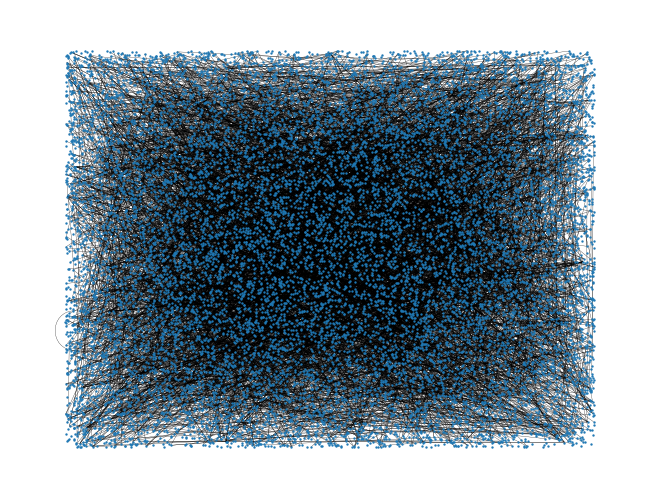

In [48]:
networkx_graph = to_networkx(graph)
nx.draw_random(networkx_graph, arrows=False, width=0.2, node_size=0.5, with_labels=False)

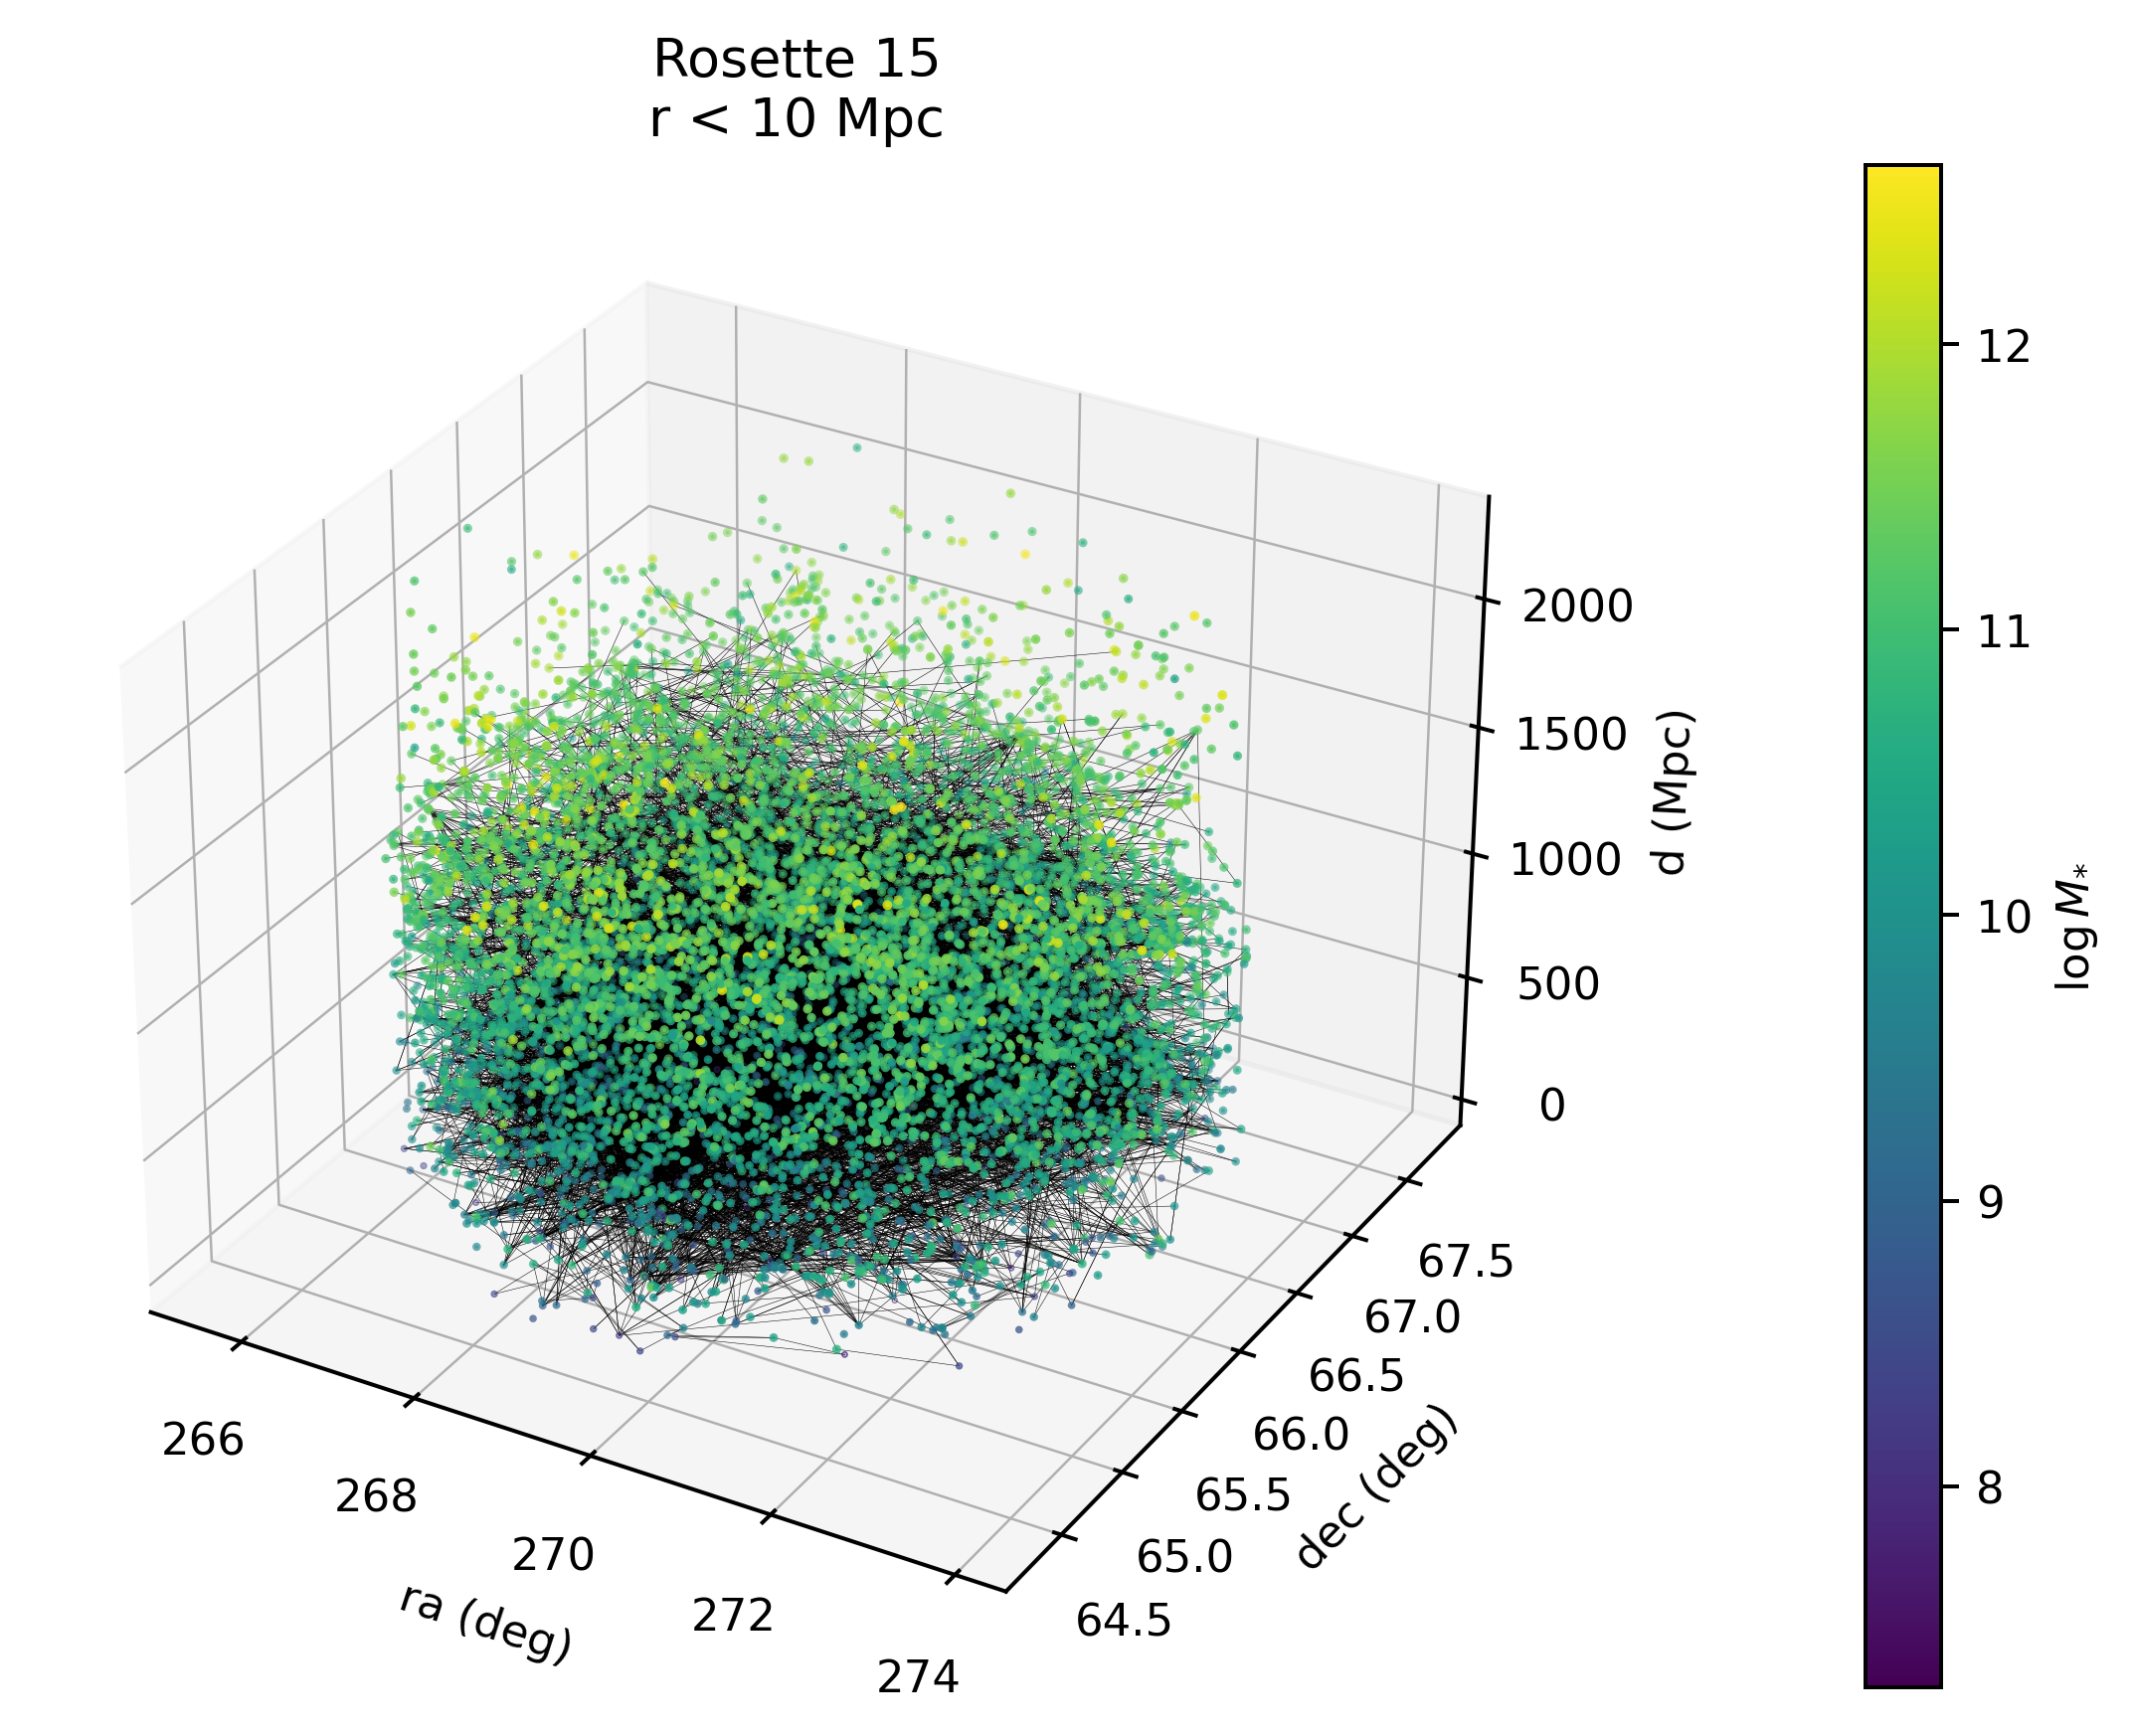

In [116]:
plt.rcParams['font.size'] = 9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.rcParams['figure.dpi'] = 360

cmap = cm.viridis
c_values = np.array([node[1] for node in node_info])
norm = (c_values - np.min(c_values)) / (np.max(c_values) - np.min(c_values))
min_norm = np.min(c_values)
max_norm = np.max(c_values)

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
sm.set_array([])

ax.scatter(edge_info[:, 1], edge_info[:, 2], edge_info[:, 3], c=cmap(norm), s=norm)

for edge in edges:
    indices = np.where(edge_info[:, 0] == edge[0])[0]
    x1, y1, z1 = edge_info[indices[0], 1:4]

    indices = np.where(edge_info[:, 0] == edge[1])[0]
    x2, y2, z2 = edge_info[indices[0], 1:4]

    ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linewidth=0.1)

ax.set_xlabel('ra (deg)')
ax.set_ylabel('dec (deg)')
ax.set_zlabel('d (Mpc)')
plt.title('Rosette 15\nr < 10 Mpc')

ax.xaxis._axinfo["grid"]['linewidth'] = 0.5
ax.yaxis._axinfo["grid"]['linewidth'] = 0.5
ax.zaxis._axinfo["grid"]['linewidth'] = 0.5

cbar = plt.colorbar(sm, ax=ax, pad=0.14)
cbar.set_label(r'$\log M_{*}$')

plt.tight_layout()
plt.show()

In [ ]:
end = t.time()
f'time: {round((end-init)/60,2)} s'

'time: 47.87 s'